# Methods for linear regression

**Goal** : We try to predict a real-valued output y (dependent variable or target) given a vector of real-valued inputs X (independent variables, explanatory variables, or covariates).

We can formulate the problem of linear regression in 2 ways :

- without regularization $$\text{argmin}_{w} \frac{1}{2} \Vert Xw - y \Vert_2^{2}$$
- with regularization $$\text{argmin}_{w} \frac{1}{2} \Vert Xw - y \Vert_2^{2} + \lambda R(w)$$

In this notebook, we will focus on **linear regression without regularization**. Nevertheless, we will briefly mention it.

Here is a quick overview of the different methods we will apply :

Method 1 : Closed-form solution

Method 2 : QR decomposition

Method 3 : Pseudoinverse

Method 4 : Gradient Descent

Method 5 : Stochastic Gradient Descent

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy

# float precision
eps = np.finfo("float").eps

# Data

First, we generate some data following a normal distribution of size (n,d). We apply this data to a linear function and adding some gaussian noise.

In [20]:
n = 100   # samples
d = 1     # dimension

X = 2 * np.random.randn(n,d)
y = 1.5 * X + 10 + np.random.randn(n, d)

Let's plot our data : (see below)

We immediatly see that our data is following a gaussian distribution, cad points are mostly grouped around 0 and only few points are far.

We will also plot the perfect target without the gaussian noise, cad the affine function given by $y = 1.5X+10$.

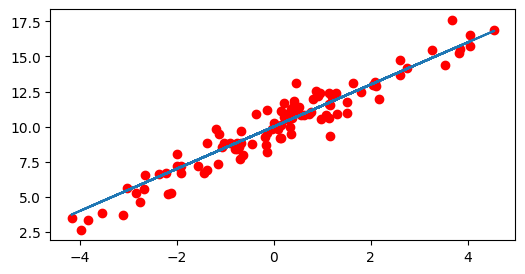

In [21]:
plt.figure(figsize=(6,3))
plt.scatter(X, y, c="r")
plt.plot(X, 1.5 * X + 10)
plt.show()

# Method 1 : Closed-form solution

First, we can directly calculate $w$ using the closed-form solution.

We will use this property (Fermat's rule) :
    $$\text{min}_{w} F(w) \Leftrightarrow \nabla F(w) = 0$$

Of course, this property is not always true and require $F(w)$ to be differentiable. In our case, we can use it !

1. Develop the term of $F(w)$

$$L(D, \boldsymbol{w})= \left\|Y - X\boldsymbol{w} \right\|^2
= (Y - X\boldsymbol{w})^\mathsf{T} (Y - X\boldsymbol{w})
= Y^\mathsf{T}Y- Y^\mathsf{T}X\boldsymbol{w}- \boldsymbol{w}^\mathsf{T}X^\mathsf{T}Y+\boldsymbol{w}^\mathsf{T}X^\mathsf{T}X\boldsymbol{w}$$

2. Calculate the gradient

$$\frac{\partial L(D, \boldsymbol{w})}{\partial \boldsymbol{w}}
= \frac{\partial \left(Y^\mathsf{T}Y- Y^\mathsf{T}X\boldsymbol{w}- \boldsymbol{w}^\mathsf{T}X^\mathsf{T}Y+\boldsymbol{w}^\mathsf{T}X^\mathsf{T}X\boldsymbol{w}\right)}{\partial \boldsymbol{w}}
= -2X^\mathsf{T}Y + 2X^\mathsf{T}X\boldsymbol{w}$$

3. Use the property

$$-2X^\mathsf{T}Y + 2X^\mathsf{T}X\boldsymbol{w} = 0
\Rightarrow X^\mathsf{T}Y = X^\mathsf{T}X\boldsymbol{w}$$

4. Find $\hat w$

$$\boldsymbol{\hat{w}} = \left(X^\mathsf{T}X\right)^{-1} X^\mathsf{T}Y$$

[[1.81069663]]


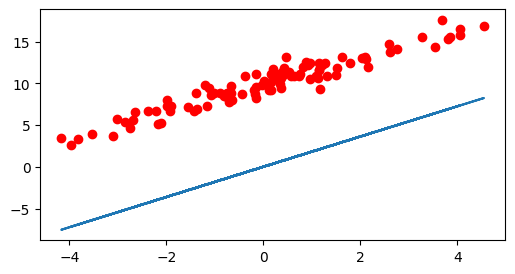

In [22]:
# without intercept
w_closed = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print(w_closed)

plt.figure(figsize=(6,3))
plt.scatter(X, y, c='r')
plt.plot(X, w_closed[0] * X)
plt.show()

Something goes wrong !
Without intercept term b, we see that the linear regression is unable to fit on the data. In some sense, the regression is shifted down to 0. To solve this problem, we have 3 solutions :
1. Add an intercept term b
$$\text{argmin}_{w,b} \frac{1}{2} \Vert Xw - y - b \mathbb{1} \Vert_2^{2}$$
2. Add a column of 1 to X
$$Xb = [X; b\mathbb{1}]$$
3. Center X and y

In our case, we will go with solution 2.

**Warning**: if regularization, it mustn't be apply to $b$.

[[9.90866426]
 [1.58279981]]


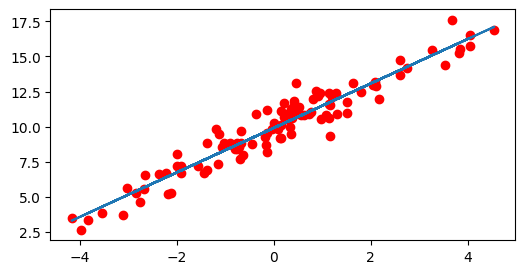

In [23]:
# add a column of 1s to X
Xb = np.c_[np.ones((n, 1)), X]

# with intercept
w_closed = np.linalg.inv(Xb.T.dot(Xb)).dot(Xb.T).dot(y)
print(w_closed)

plt.figure(figsize=(6,3))
plt.scatter(X, y, c='r')
plt.plot(X, w_closed[1] * X + w_closed[0])
plt.show()

It's working !

**Remarks** : 
- The intercept term $b$ correct the deviation of our regression.
- The values obtain are close but not equal to the true one, this is due to gaussian noise which deforms our data.

We are lucky, a function to calculate the pseudoinverse is already implemented in numpy (`np.linalg.pinv`). One can see that we obtain the same result (ouf!) :

In [24]:
w_pinv = np.linalg.pinv(Xb).dot(y)
print(w_pinv)

[[9.90866426]
 [1.58279981]]


# Method 2 : QR decomposition

One way to decompose a matrix is the QR decomposition. In brief, we will have $X=QR$ with $Q$ a matrix with orthonormal columns and $R$ an upper triangular matrix.

1. QR decomposition of $X$
$$QRw = y$$
2. Multiply by $Q^\top$ :
$$Q^\top Q R w = Q^\top y$$
3. Calculate $\hat w$ :
$$\hat w = R^{-1}Q^\top y$$

**Remark** : Since $R$ is upper triangular, we can solve this last set of equations using backsubstitution, thus avoiding matrix inversion.

In [25]:
Q, R = np.linalg.qr(Xb)
Qy = np.dot(Q.T, y)
w_qr = scipy.linalg.solve_triangular(R, Qy)
print(w_qr)

[[9.90866426]
 [1.58279981]]


# Method 3 : Pseudoinverse

Singular Values Decomposition (SVD) is another way to decompose a matrix.

1. SVD decomposition of $X$
$$X = U \Sigma V^{\top}$$
2. Calculate Moore Penrose inverse
$$ X^{+} = V \Sigma^{+} U^{\top}$$
3. Calculate $\hat w$
$$\hat w = X^{+}y$$

**Remark** : To obtain $\Sigma^{+}$, we will put to zero small values of $\Sigma$ and calculate the inverse of nonzero elements

**Reminder** : $\Sigma$ is a diagonal matrix containing singular values

In [26]:
# svd decomposition
U, sigma, Vt = np.linalg.svd(Xb)

# pseudoinverse
sigma[sigma < 1e-2] = 0
sigma_plus = 1/sigma
X_plus = Vt.T @ (sigma_plus * U[:,:2]).T

w_pinv = X_plus @ y
print(w_pinv)

[[9.90866426]
 [1.58279981]]


We can also use `LinearRegression` from `sklearn.linear_model` to obtain the same results. This is the methods currently use in Scikit-learn.

In [27]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
print(lin_reg.intercept_, lin_reg.coef_)

[9.90866426] [[1.58279981]]


# Method 4 : Gradient descent

Gradient descent (GD) is a maximization-minimization procedure : it finds an upper bound of the function and minimize it.

One iteration of gradient descent is given by :
$$w_{t+1} = w_{t} - \alpha \nabla f(w_{t})$$

It's interesting to understand the gradient of $F$ (cad $\nabla F$) in the formula. The gradient gives the steepest direction, so if we take minus the gradient we have the direction of the largest descent. Under some assumptions on F, by following the largest descent, we will find the global minimum.

- Mean-Squared error (MSE) formula :

$$MSE(\theta) = \frac{1}{n} \sum^{n}_{i=1} (\hat y^{(i)} - y^{(i)})^{2}$$

- Gradient of MSE :

$$\frac{\partial}{\partial \theta_{j}} MSE(\theta) = \frac{2}{n} \sum^{n}_{i=1} (\hat y^{(i)} - y^{(i)}) x^{(i)}_{j}$$

In [28]:
def MSE(y, w, X):
    return 1/y.shape[0] * np.linalg.norm(X @ w - y, axis=0) ** 2

def grad_MSE(y, w, X):
    return 2/n * X.T.dot(X.dot(w) - y)

# find the optimum value with Gauss pivot
w_best = scipy.linalg.solve(Xb.T @ Xb, Xb.T @ y)
mse_best = MSE(y, w_best, Xb)

print(mse_best)

[0.73070493]


In [52]:
lr = 0.1 # learning rate

def gd(lr):
    w = np.random.randn(2,1)
    objs = []
    for epoch in range(1000):
        w = w - lr * grad_MSE(y, w, Xb)
        objs.append(MSE(y, w, Xb))
    return w, objs

w_gd, objs_gd = gd(lr=lr)
print(w_gd)
print("MSE:", objs_gd[-1])

[[9.90866426]
 [1.58279981]]
MSE: [0.73070493]


**Remark** :
- We are doing 1000 epochs. One epoch correspond to one iteration of the whole dataset.
- We set the learning rate, this parameter decide at which speed we will converge. Nevertheless, if it's to high, we may encounter some issue and never reach the minima.
- We reach the same MSE compared to Gauss pivot (`scipy.linalg.solve`).

# Method 5 : Stochastic Gradient Descent (SGD)

Stochastic Gradient Descent (SGD) is close to GD, but it will sample uniformly one example from $X$ and only compute is gradient. SGD is stochastic because of this randomness in the choose of $i$.

The main difference between GD and SGD is the complexity. SGD only needs one sample by iteration, compared to $n$ for GD.
Of course, there are also other differences, e.g. rate of convergence, deterministic vs stochastic.

- Algorithm :
$$sample \space i \space uniformly \space \{1,..., n\}$$
$$w_{t+1} = w_{t} - \alpha \nabla f(x_{t}^{(i)})$$

In [55]:
def sgd(lr):
    w = np.random.randn(2,1)
    objs = []
    for _ in range(10000):
        # sample 1 id uniformly
        i = np.random.randint(low=0, high=n, size=1)
        w = w - lr * grad_MSE(y[i], w,  Xb[i])
        objs.append(MSE(y, w, Xb))
    return w, objs

w_sgd, objs_sgd = sgd(lr=lr)
print(w_sgd)
print("MSE:", objs_sgd[-1])

[[9.90599281]
 [1.54790709]]
MSE: [0.73502584]


**Remarks** :
- We haven't the same MSE than with Gradient Descent. We see that this methods converges less better compared to GD.
- We will not obtain the same results if we reexecute the algorithm

Let's plot the evolution of the MSE both for GD and SGD compared to the number of iterations

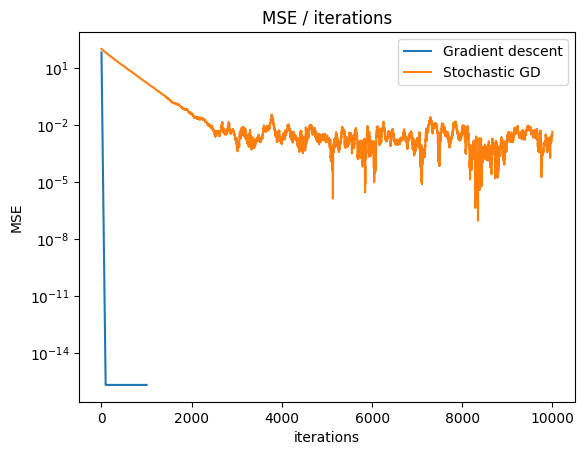

In [56]:
plt.figure()
plt.title("MSE / iterations")
plt.semilogy(np.maximum(objs_gd-mse_best, eps), label="Gradient descent")
plt.semilogy(np.maximum(objs_sgd-mse_best, eps), label="Stochastic GD")
plt.xlabel("iterations")
plt.ylabel("MSE")
plt.legend()
plt.show()

**Remarks** :
- We see GD converges linearly with in a logarithmic scale. For SGD, it's the case only at the beginning.
- SGD converges really slower than GD, so what it's interest ? Let's look at the next plot (below)

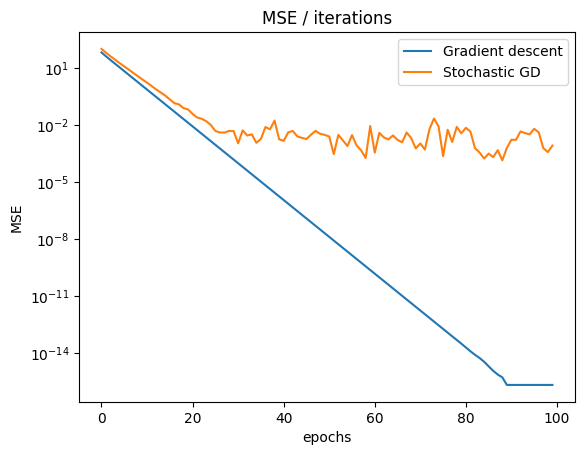

In [57]:
plt.figure()
plt.title("MSE / iterations")
plt.semilogy(np.maximum(objs_gd-mse_best, eps)[:100], label="Gradient descent")
plt.semilogy(np.maximum(objs_sgd-mse_best, eps)[::n], label="Stochastic GD")
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()

**Remarks** :
- For GD, the plot is the same because one epoch is one iteration
- At the beginning, we see that SGD converges almost as GD. In reality, it will often converges faster but this isn't observable on our dataset because $n$ is too small.

# Conclusion
We saw some methods to resolve the linear regression problem. I didn't spend lot of time explaining assumption and the pros/cons of each methods, but in cases, some methods can be untractable. And you will have no choice to use another one.

Of course, there are lot of other methods for this problem. The example of linear regression is really easy, bit it's really nice and understand each method with just some calculus and intuition.

# Next step
Look at linear regression with regularization ($l_1$ and $l_2$ norm).